In [1]:
%matplotlib inline
import os
from osgeo import gdal
import rasterio
import geopandas as gpd
import rasterio.mask
from rasterio.windows import Window
import sys
import matplotlib.pyplot as plt
from shapely.geometry import mapping
sys.path.append(r'E:/gitlab/geoloc2/Detecciondeterrenos')
###path de yolo dentro de computadora
os.chdir(r'C:/Users/ASUS/Inteligencia_Artificial/yolov7')
# sys.path.append(r'C:\Users\mfpen\Documents\Repositorios\geoloc2\Detecciondeterrenos')
###path de yolo dentro de computadora
# os.chdir(r'C:\Users\mfpen\OneDrive\Documentos\Secretaría\yolov7')
from detect_Alberto_v4 import *
from scipy.ndimage import rotate as rotate_image
from shapely import geometry
import time
import datetime

In [2]:
# import warnings
# warnings.filterwarnings('ignore')
# import pandas as pd
# import math
# from shapely.geometry import Polygon
# import cv2
# from clasificacion_chinchetas import *
# import tqdm
# import numpy as np
# from osgeo import gdal
# import rasterio
# import geopandas as gpd
# import rasterio.mask
# import sys
# from shapely.geometry import mapping
# from shapely import geometry
# import cv2
# import numpy as np

## Raster y shape deteccion

In [3]:
# raster=r"C:\Users\mfpen\Pictures\Ixtapan_Sal.tif"
raster=r"C:\Users\ASUS\Desktop\atlacomulco.tif"
# src=rasterio.open(raster)

# deteccion=r"D:\Secretaría\salida_detecciones\Ixtapan\Ixtapan_Sal_casas.shp"
deteccion=r"E:\rastermunicpial\atlacomulco\atlacomulco_sinfitlro\Atlacomulco_casas.shp"
deteccion_shp=gpd.read_file(deteccion)


In [4]:
deteccion_shp

,clase_dete,conf,area,geometry
0,establecimiento,0.70136,511.425330,"POLYGON ((-11128880.49126 2257468.09239, -1112..."
1,casas,0.82655,182.508647,"POLYGON ((-11128892.61083 2257473.46095, -1112..."
2,establecimiento,0.55637,322.899914,"POLYGON ((-11128694.81898 2256336.11839, -1112..."
3,establecimiento,0.55807,465.296771,"POLYGON ((-11128701.05797 2256325.98240, -1112..."
4,establecimiento,0.65544,187.522621,"POLYGON ((-11128689.16548 2256344.33883, -1112..."
...,...,...,...,...
58498,establecimiento,0.38781,1073.993192,"POLYGON ((-11100378.96465 2243765.86925, -1110..."
58499,terreno_baldio,0.53138,361.006115,"POLYGON ((-11099962.90156 2245884.15924, -1109..."
58500,establecimiento,0.62800,210.586900,"POLYGON ((-11099531.66920 2242100.27655, -1109..."
58501,establecimiento,0.24212,195.544979,"POLYGON ((-11099429.33170 2243560.90312, -1109..."


In [5]:
def ampliar_shape(shape,factor_ampliacion=2):
    """Amplifica el polygon de cada manzana con el fin de extrar imagenes sin perder informacion de la manzana"""
    shape["geometry"]=shape["geometry"]
    shape['centroid']=shape.centroid
    geometry=[]
    clase=[]
    for i,polygon in enumerate(shape['geometry']):
        # try:
        point=mapping(shape['centroid'][i]).get('coordinates')
        # except:
        #     continue
        x=point[0]
        y=point[1]
        go=[]
        coodinates=mapping(polygon).get('coordinates')[0]
        for a in coodinates:
            x1=a[0]
            y1=a[1]
            x2=x+(x1-x)*factor_ampliacion
            y2=y+(y1-y)*factor_ampliacion
            go.append((x2,y2))
        geometry.append(Polygon(go))
        clase.append(shape.loc[i,"clase_dete"])
    return gpd.GeoDataFrame({"clase_dete":clase},geometry=geometry)

In [6]:
deteccion_shp=deteccion_shp.dropna(how="all").reset_index(drop=True)
angulo_manzana=[]
for manzana in range(len(deteccion_shp)):
    proyecciones1=mapping(deteccion_shp['geometry'][manzana]).get('coordinates')
    angulos=[]
    d=[]
    poly=pd.DataFrame(proyecciones1[0])
    for point in range(1,len(poly)):
        d.append(((poly[1][point]-poly[1][point-1])**2+(poly[0][point]-poly[0][point-1])**2))
#         angulos.append(math.atan(((poly[1][point]-poly[1][point-1])/(poly[0][point]-poly[0][point-1])))*180/math.pi)
#     angulo_manzana.append(angulos[d.index(max(d))])
# deteccion_shp['angulo']=angulo_manzana
deteccion_shp1=ampliar_shape(deteccion_shp,factor_ampliacion=1.25)
len(deteccion_shp1)

58503

## Clasificar casas y/o terrenos (Alexnet)

##### Pesos y diccionario Alexnet

In [7]:
# weights=r'C:\Users\ASUS\Inteligencia_Artificial\clasificador\ckpoint/best_mod11.pth'
# num_classes=5
# diciconario={0: 'casas', 1: 'en_construccion', 2: 'establecimiento', 3: 'multivivienda', 4: 'terreno_baldio'}
# model_class=alexnet(weights=weights,num_classes=num_classes,idx_to_class=diciconario)


# weights=r"C:\Users\ASUS\Inteligencia_Artificial\clasificador\ckpoint\best_modell11.pth"
# num_classes=6
# diciconario={0: 'carros', 1: 'casas', 2: 'en_construccion', 3: 'establecimiento', 4: 'multivivienda', 5: 'terreno_baldio'}
# model_class=alexnet(weights=weights,num_classes=num_classes,idx_to_class=diciconario)

#### Clasificación

In [8]:
def normalizar_array(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))

In [9]:
deteccion_shp.dropna(how="all")

,clase_dete,conf,area,geometry,centroid
0,establecimiento,0.70136,511.425330,"POLYGON ((-11128880.49126 2257468.09239, -1112...",POINT (-11128867.77190 2257456.41801)
1,casas,0.82655,182.508647,"POLYGON ((-11128892.61083 2257473.46095, -1112...",POINT (-11128887.84613 2257465.16540)
2,establecimiento,0.55637,322.899914,"POLYGON ((-11128694.81898 2256336.11839, -1112...",POINT (-11128685.85688 2256326.04648)
3,establecimiento,0.55807,465.296771,"POLYGON ((-11128701.05797 2256325.98240, -1112...",POINT (-11128689.51610 2256314.07424)
4,establecimiento,0.65544,187.522621,"POLYGON ((-11128689.16548 2256344.33883, -1112...",POINT (-11128682.63677 2256336.58205)
...,...,...,...,...,...
58498,establecimiento,0.38781,1073.993192,"POLYGON ((-11100378.96465 2243765.86925, -1110...",POINT (-11100367.90158 2243740.56343)
58499,terreno_baldio,0.53138,361.006115,"POLYGON ((-11099962.90156 2245884.15924, -1109...",POINT (-11099963.37468 2245870.69318)
58500,establecimiento,0.62800,210.586900,"POLYGON ((-11099531.66920 2242100.27655, -1109...",POINT (-11099531.13610 2242090.01543)
58501,establecimiento,0.24212,195.544979,"POLYGON ((-11099429.33170 2243560.90312, -1109...",POINT (-11099424.35028 2243552.30224)


In [10]:
deteccion_shp1

,clase_dete,geometry
0,establecimiento,"POLYGON ((-11128883.671 2257471.011, -11128847..."
1,casas,"POLYGON ((-11128893.802 2257475.535, -11128877..."
2,establecimiento,"POLYGON ((-11128697.060 2256338.636, -11128669..."
3,establecimiento,"POLYGON ((-11128703.943 2256328.959, -11128669..."
4,establecimiento,"POLYGON ((-11128690.798 2256346.278, -11128670..."
...,...,...
58498,establecimiento,"POLYGON ((-11100381.730 2243772.196, -11100335..."
58499,terreno_baldio,"POLYGON ((-11099962.783 2245887.526, -11099946..."
58500,establecimiento,"POLYGON ((-11099531.802 2242102.842, -11099518..."
58501,establecimiento,"POLYGON ((-11099430.577 2243563.053, -11099412..."


In [11]:
geometry=[]
status=[]

In [12]:
# sh=gpd.read_file(r"E:\rastermunicpial/test_nauc_2_nuevarotacion.shp")
# status=list(sh["status"].values)
# geometry=list(sh["geometry"].values)


In [17]:
%matplotlib
import tqdm
import cv2
geometry3=[]
status3=[]
with rasterio.open(raster) as src:
    for i,polygo in tqdm.tqdm(enumerate(deteccion_shp1["geometry"]),total=len(deteccion_shp1)):
        det="a"
        # if i<47961:
        #     continue
        try:
            shapes=[mapping(polygo)]
        except:
            print(i)
            continue
    #     out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        array, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        imagen=cv2.cvtColor(np.moveaxis(array,0,-1),cv2.COLOR_RGB2BGR)
        # cv2_imshow(imagen)
        imagen=np.array(imagen,dtype='float32')/255
        img=imagen.copy()
        # img=np.array(img,"float")
        # for channel in range(img.shape[2]):
        for y in range(1,img.shape[0]-1):
            for x in range(1,img.shape[1]-1):
                for w in range(-1,2):
                    for h in range(-1,2):
                        if np.min(np.abs(img[y+h,x+w,:]-img[y,x,:]))*255<=20:
                            # print(y,x,w,h)
                            img[y+h,x+w,:]=img[y,x,:]
                        # print(imagen[y,x,:])
        # print(img.shape)
        
        # maximo=np.max(img)
        # minimo=np.min(img)
        # cv2_imshow(img)
        # cv2.waitKey()
        # cv2.destroyAllWindows()
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gray=(normalizar_array(gray)*2-1)*255
        # plt.imshow(gray)
        # break
        y=gray.copy()
        y[y<5]=0
        y[y>=5]=255
        gray=cv2.erode(y,(6,6))
        # plt.imshow(gray)
        # break
        # cv2_imshow("y",np.array(np.hstack([gray,imagen[:,:,0]]),dtype="uint8"))
        # img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        # img=(np.array(img[:,:,1],dtype=float)*255)**2
        img=(np.array(y,dtype=float)*255)**2
        # break
        h,w= img.shape
        # plt.imshow(gray)
        # break
        yc,xc=int(h/2),int(w/2)
        thres=img.copy()
        u=190
        thres[thres<u**2]=0
        thres[thres>=u**2]=255
        thres=np.array(thres,dtype="uint8")#_,thres=cv2.threshold(img,173,255,1)
        # plt.imshow(thres)
        # break
        f=1.25
        kernel = np.array([[-1,-1,1],[-1,1,-1],[1,-1,-1]])
        kernel=np.array([[1,1,1],[0,0,1],[0,0,1]])
        dst = cv2.filter2D(thres,-1,kernel)
        cont,hist=cv2.findContours(dst,2,1)
        res=pd.DataFrame({"c":cont,"area":[cv2.contourArea(cnt) for cnt in cont]})
        res.sort_values(by="area",ascending=False,inplace=True)
        res=res.reset_index(drop=True)
        try:
            cnt=res.c.values[0]
        except:
            deteccion_shp.loc[i,"geometry2"]=polygo
            deteccion_shp.loc[i,"status"]="error"
            # print("aca")
            continue
        if res.loc[0,"area"]<.5*polygo.area:
            deteccion_shp.loc[i,"geometry2"]=polygo
            deteccion_shp.loc[i,"status"]="area_small"
            # print("aqui")
            continue
        epsilon = 0.03*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        cnt=approx
        s=np.zeros_like(dst)
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        coords=shapes[0].get("coordinates")[0]
        left,bottom=np.min(coords,axis=0)
        right,top=np.max(coords,axis=0)
        height=imagen.shape[0]
        width=imagen.shape[1]
        cv2.drawContours(s,[box],0,(127),2)
        cv2.drawContours(s,[cnt],-1,(255),-1)

        deteccion_shp.loc[i,"geometry2"]=Polygon([(map_d(x[0],0,width,left,right),map_d(x[1],height,0,bottom,top)) for x in box])
        deteccion_shp.loc[i,"status"]="correcto"
        # cv2_imshow(s)
        # plt.show()
        #break
        # gray = np.float32(gray)
        # dst = cv.cornerHarris(gray,2,3,0.04)
        # dst[dst<=0]=0
        # dst=dst
        # sa=dst.copy()
        # sa=sa.reshape(-1)
        # sa.sort()
        # box=np.moveaxis(np.where(dst>=sa[-4]),0,-1)
        # # print(box)
        # box=np.stack([box[:,1],box[:,0]],axis=-1)
        # # box
        # # cv2.drawContours(img,[box],0,(0,0,255),2)
        # cv2_imshow("s",img)
    #     rows,cols = img.shape[:2]
    #     [vx,vy,x,y] = cv.fitLine(box, cv.DIST_L2,0,0.01,0.01)
    #     lefty = int((-x*vy/vx) + y)
    #     righty = int(((cols-x)*vy/vx)+y)
    #     cv.line(img,(cols-1,righty),(0,lefty),(0,255,0),2)
    #     cv2_imshow("s",img)
    #     # four_images=[array[2],array[1],array[0]]
    #     # stacked_images = np.stack(four_images, axis=-1)
        
    # #     imagen_1=rotate_image(stacked_images,deteccion_shp["angulo"][i],reshape=False)
    # #     clase,imagen=model_class.predict_image(imagen_1)
        
    # #     cv2.|imshow("im",imagen)
    # #     cv2.waitKey()
    # #     cv2.destroyAllWindows()
    #     deteccion_shp.loc[i,"clase_n"]=clase

Using matplotlib backend: Qt5Agg


 12%|█▏        | 7158/58503 [36:30<4:21:55,  3.27it/s] 


KeyboardInterrupt: 

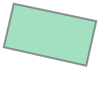

In [16]:
# Polygon([(map_d(x[0],0,width,left,right),map_d(x[1],height,0,bottom,top)) for x in box])

In [ ]:
# ñ

In [ ]:
# status1=status.copy()
# geometry1=geometry.copy()

In [ ]:
# status10=status1[:47961]+[status3]+status1[47961:]
# geometry10=geometry1[:47961]+[geometry3]+geometry1[47961:]

In [ ]:
# deteccion_shp['status']= status10
# deteccion_shp['geometry']=geometry10

In [ ]:
deteccion_shp.drop(['centroid'],axis=1,inplace=True)


In [ ]:
deteccion_shp.to_file(r"E:\rastermunicpial\naucalpan/Naucalpan_casas_nueva_rotacion.shp")

In [ ]:
# gpd.GeoDataFrame({"status":status},geometry=geometry,crs=3857).to_file(r"E:\rastermunicpial/test_nauc_2_nuevarotacion.shp")


In [ ]:
# atlaconuevo=gpd.read_file(r"C:\Users\ASUS\Desktop\vero\atlaco\test_altlaco_2_nuevarotacion.shp")

In [ ]:
# atlaco=gpd.read_file(r"E:\rastermunicpial\atlacomulco\atlacomulco_sinfitlro\Atlacomulco_casas.shp")

In [ ]:
# atlaconuevo1=atlaconuevo.copy()
# atlaconuevo1["geometry"]=atlaconuevo1["geometry"].centroid
# cruce=gpd.sjoin(atlaco,atlaconuevo1,predicate='contains')

In [ ]:
# cruce.reset_index(drop=False,inplace=True)
# cruce[cruce["index"]==21956]

In [ ]:
# atlaco.sjoin_nearest(atlaconuevo1,max_distance=1)

In [ ]:
# import geopandas as gpd